# Regression

*Supervised* machine learning techniques involve training a model to operate on a set of *features* and predict a *label* using a dataset that includes some already-known label values. The training process *fits* the features to the known labels to define a general function that can be applied to new features for which the labels are unknown, and predict them. You can think of this function like this, in which ***y*** represents the label we want to predict and ***x*** represents the features the model uses to predict it.

$$y = f(x)$$

In most cases, *x* is actually a *vector* that consists of multiple feature values, so to be a little more precise, the function could be expressed like this:

$$y = f([x_1, x_2, x_3, ...])$$

The goal of training the model is to find a function that performs some kind of calculation to the *x* values that produces the result *y*. We do this by applying a machine learning *algorithm* that tries to fit the *x* values to a calculation that produces *y* reasonably accurately for all of the cases in the training dataset.

There are lots of machine learning algorithms for supervised learning, and they can be broadly divided into two types:

- **_Regression_ algorithms**: Algorithms that predict a *y* value that is a numeric value, such as the price of a house or the number of sales transactions.
- **_Classification_ algorithms**: Algorithms that predict to which category, or *class*, an observation belongs. The *y* value in a classification model is a vector of probability values between 0 and 1, one for each class, indicating the probability of the observation belonging to each class.

In this notebook, we'll focus on *regression*, using an example based on a real study in which data for a bicycle sharing scheme was collected and used to predict the number of rentals based on seasonality and weather conditions. We'll use a simplified version of the dataset from that study.

> **Citation**: The data used in this exercise is derived from [Capital Bikeshare](https://www.capitalbikeshare.com/system-data) and is used in accordance with the published [license agreement](https://www.capitalbikeshare.com/data-license-agreement).

## Explore the Data

The first step in any machine learning project is to explore the data that you will use to train a model. The goal of this exploration is to try to understand the relationships between its attributes; in particular, any apparent correlation between the *features* and the *label* your model will try to predict. This may require some work to detect and fix issues in the data (such as dealing with missing values, errors, or outlier values), deriving new feature columns by transforming or combining existing features (a process known as *feature engineering*), *normalizing* numeric features (values you can measure or count) so they're on a similar scale, and *encoding* categorical features (values that represent discrete categories) as numeric indicators.

Let's start by loading the bicycle sharing data as a **Pandas** DataFrame and viewing the first few rows.

In [48]:
# Importing all necessary packages at the start of the notebook
import pandas as pd
import numpy as np
import scipy.stats as stats
from matplotlib import pyplot as plt
%matplotlib inline
import urllib.request
from os.path import exists
from sklearn.preprocessing import MinMaxScaler

In [49]:
url = 'https://raw.githubusercontent.com/MicrosoftDocs/mslearn-introduction-to-machine-learning/main/Data/ml-basics/daily-bike-share.csv'
filename = 'dataset/regression/daily-bike-share.csv.csv'
if not exists(filename):
    urllib.request.urlretrieve(url, filename)
else:
    print(f'{filename} file already present')

bike_data = pd.read_csv(filename)
bike_data.head()

dataset/regression/daily-bike-share.csv.csv file already present


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,rentals
0,1,1/1/2011,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331
1,2,1/2/2011,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131
2,3,1/3/2011,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120
3,4,1/4/2011,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108
4,5,1/5/2011,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82


The data consists of the following columns:

- **instant**: A unique row identifier
- **dteday**: The date on which the data was observed - in this case, the data was collected daily; so there's one row per date.
- **season**: A numerically encoded value indicating the season (1:spring, 2:summer, 3:fall, 4:winter)
- **yr**: The year of the study in which the observation was made (the study took place over two years - year 0 represents 2011, and year 1 represents 2012)
- **mnth**: The calendar month in which the observation was made (1:January ... 12:December)
- **holiday**: A binary value indicating whether or not the observation was made on a public holiday)
- **weekday**: The day of the week on which the observation was made (0:Sunday ... 6:Saturday)
- **workingday**: A binary value indicating whether or not the day is a working day (not a weekend or holiday)
- **weathersit**: A categorical value indicating the weather situation (1:clear, 2:mist/cloud, 3:light rain/snow, 4:heavy rain/hail/snow/fog)
- **temp**: The temperature in celsius (normalized)
- **atemp**: The apparent ("feels-like") temperature in celsius (normalized)
- **hum**: The humidity level (normalized)
- **windspeed**: The windspeed (normalized)
- **rentals**: The number of bicycle rentals recorded.

In this dataset, **rentals** represents the label (the *y* value) our model must be trained to predict. The other columns are potential features (*x* values).

As mentioned previously, you can perform some *feature engineering* to combine or derive new features. For example, let's add a new column named **day** to the dataframe by extracting the day component from the existing **dteday** column. The new column represents the day of the month from 1 to 31.

In [50]:
bike_data['day'] = pd.DatetimeIndex(bike_data['dteday']).day
bike_data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,rentals,day
0,1,1/1/2011,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,1
1,2,1/2/2011,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,2
2,3,1/3/2011,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,3
3,4,1/4/2011,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,4
4,5,1/5/2011,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,5


In [51]:
numeric_features = ['temp', 'atemp', 'hum', 'windspeed']
bike_data[numeric_features + ['rentals']].describe()

,temp,atemp,hum,windspeed,rentals
count,731.000000,731.000000,731.000000,731.000000,731.000000
mean,0.495385,0.474354,0.627894,0.190486,848.176471
std,0.183051,0.162961,0.142429,0.077498,686.622488
min,0.059130,0.079070,0.000000,0.022392,2.000000
25%,0.337083,0.337842,0.520000,0.134950,315.500000
50%,0.498333,0.486733,0.626667,0.180975,713.000000
75%,0.655417,0.608602,0.730209,0.233214,1096.000000
max,0.861667,0.840896,0.972500,0.507463,3410.000000


The statistics reveal some information about the distribution of the data in each of the numeric fields, including the number of observations (there are 731 records), the mean, standard deviation, minimum and maximum values, and the quartile values (the threshold values for 25%, 50% - which is also the median, and 75% of the data). From this, we can see that the mean number of daily rentals is around 848; but there's a comparatively large standard deviation, indicating a lot of variance in the number of rentals per day.

We might get a clearer idea of the distribution of rentals values by visualizing the data. Common plot types for visualizing numeric data distributions are *histograms* and *box plots*, so let's use Python's **matplotlib** library to create one of each of these for the **rentals** column.

Text(0.5, 0.98, 'Rental Distribution')

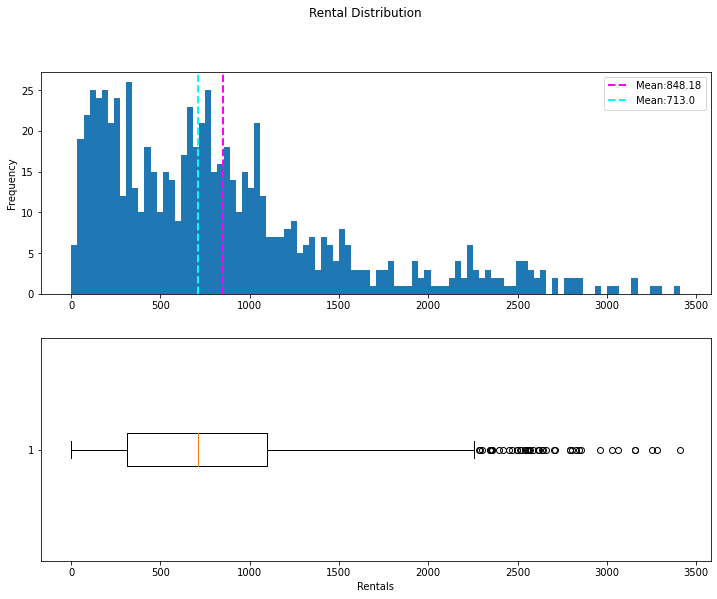

In [52]:
# Get the label column
label = bike_data['rentals']


# Create a figure for 2 subplots (2 rows, 1 column)
fig, ax = plt.subplots(2, 1, figsize = (12,9))

# Plot the histogram   
ax[0].hist(label, bins=100)
ax[0].set_ylabel('Frequency')

# Add lines for the mean, median, and mode
ax[0].axvline(label.mean(), color='magenta', linestyle='dashed', linewidth=2, label='Mean:'+str(round(label.mean(),2)))
ax[0].axvline(label.median(), color='cyan', linestyle='dashed', linewidth=2, label='Mean:'+str(round(label.median(),2)))
ax[0].legend()
# Plot the boxplot   
ax[1].boxplot(label, vert=False)
ax[1].set_xlabel('Rentals')

# Add a title to the Figure
fig.suptitle('Rental Distribution')

The plots show that the number of daily rentals ranges from 0 to just over 3,400. However, the mean (and median) number of daily rentals is closer to the low end of that range, with most of the data between 0 and around 2,200 rentals. The few values above this are shown in the box plot as small circles, indicating that they are *outliers* - in other words, unusually high or low values beyond the typical range of most of the data.

We can do the same kind of visual exploration of the numeric features. Let's create a histogram for each of these.

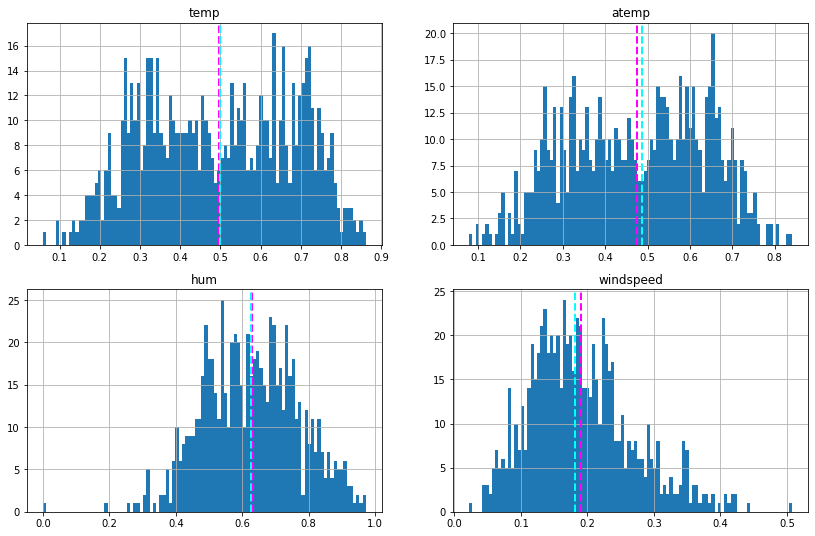

In [53]:
# Plot a histogram for each numeric feature
fig, ax = plt.subplots(2, 2, figsize = (14,9))

for i,col in enumerate(numeric_features):
    if i==0: fig_row=0; fig_col=0
    if i==1: fig_row=0; fig_col=1
    if i==2: fig_row=1; fig_col=0
    if i==3: fig_row=1; fig_col=1
    feature = bike_data[col]
    feature.hist(bins=100, ax = ax[fig_row,fig_col])
    ax[fig_row,fig_col].axvline(feature.mean(), color='magenta', linestyle='dashed', linewidth=2, label='Mean:'+str(round(feature.mean(),2)))
    ax[fig_row,fig_col].axvline(feature.median(), color='cyan', linestyle='dashed', linewidth=2, label='Mean:'+str(round(feature.median(),2)))
    ax[fig_row,fig_col].set_title(col)
plt.show()

The numeric features seem to be more *normally* distributed, with the mean and median nearer the middle of the range of values, coinciding with where the most commonly occurring values are.

> **Note**: The distributions are not truly *normal* in the statistical sense, which would result in a smooth, symmetric "bell-curve" histogram with the mean and mode (the most common value) in the center; but they do generally indicate that most of the observations have a value somewhere near the middle.

We've explored the distribution of the numeric values in the dataset, but what about the categorical features? These aren't continuous numbers on a scale, so we can't use histograms; but we can plot a bar chart showing the count of each discrete value for each category.

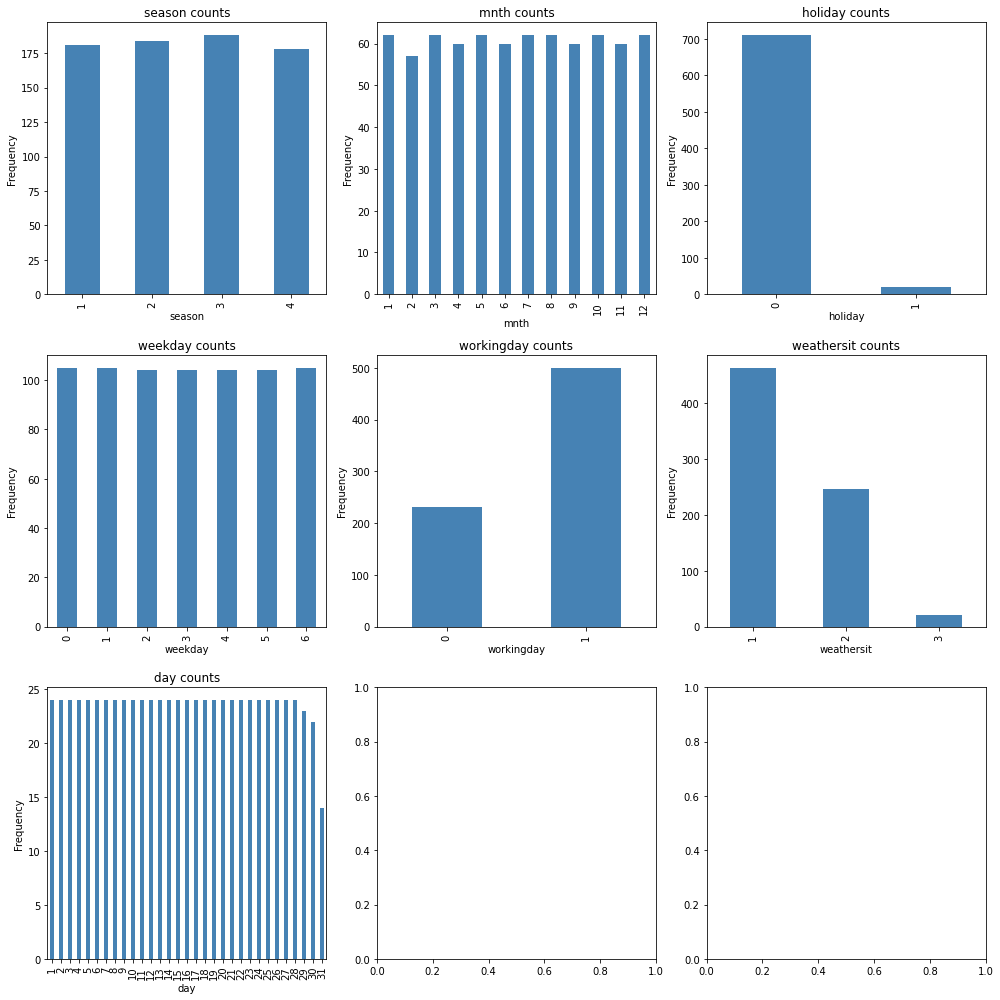

In [54]:
# plot a bar plot for each categorical feature count
categorical_features = ['season','mnth','holiday','weekday','workingday','weathersit', 'day']
fig, ax = plt.subplots(3, 3, figsize = (14,14))

for i,col in enumerate(categorical_features):
    if i==0: fig_row=0; fig_col=0
    if i==1: fig_row=0; fig_col=1
    if i==2: fig_row=0; fig_col=2
    if i==3: fig_row=1; fig_col=0
    if i==4: fig_row=1; fig_col=1
    if i==5: fig_row=1; fig_col=2
    if i==6: fig_row=2; fig_col=0
    if i==7: fig_row=2; fig_col=1
    counts = bike_data[col].value_counts().sort_index()
    counts.plot.bar(ax = ax[fig_row,fig_col], color='steelblue')
    ax[fig_row,fig_col].set_title(col + ' counts')
    ax[fig_row,fig_col].set_xlabel(col) 
    ax[fig_row,fig_col].set_ylabel("Frequency")
fig.tight_layout()

Many of the categorical features show a more or less *uniform* distribution (meaning there's roughly the same number of rows for each category). Exceptions to this include:

- **holiday**: There are many fewer days that are holidays than days that aren't.
- **workingday**: There are more working days than non-working days.
- **weathersit**: Most days are category *1* (clear), with category *2* (mist and cloud) the next most common. There are comparatively few category *3* (light rain or snow) days, and no category *4* (heavy rain, hail, or fog) days at all.

Now that we know something about the distribution of the data in our columns, we can start to look for relationships between the features and the **rentals** label we want to be able to predict.

For the numeric features, we can create scatter plots that show the intersection of feature and label values. We can also calculate the *correlation* statistic to quantify the apparent relationship.. 

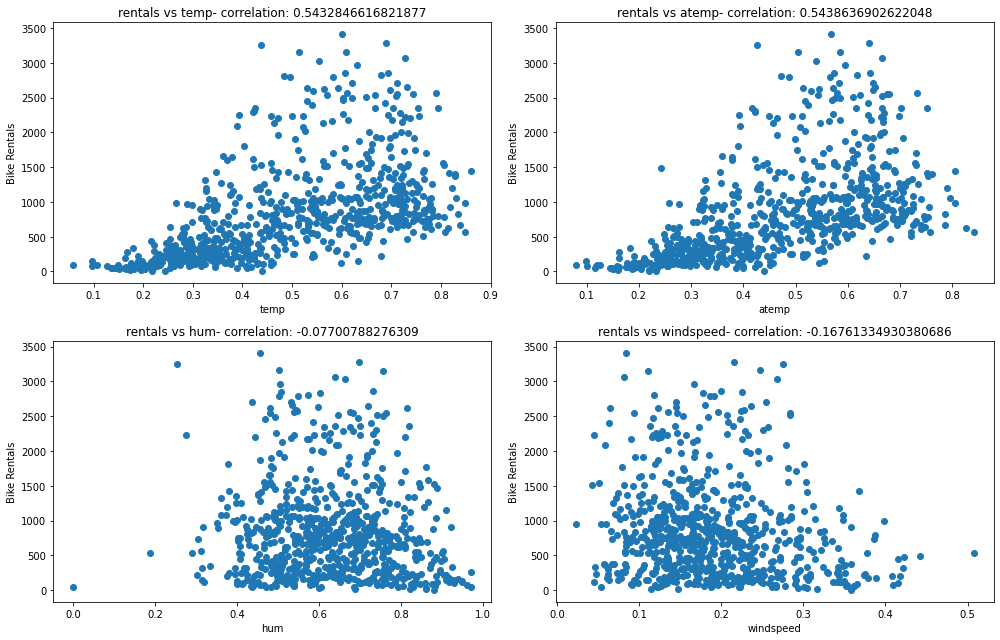

In [55]:
# Plot a histogram for each numeric feature
fig, ax = plt.subplots(2, 2, figsize = (14,9))

for i,col in enumerate(numeric_features):
    if i==0: fig_row=0; fig_col=0
    if i==1: fig_row=0; fig_col=1
    if i==2: fig_row=1; fig_col=0
    if i==3: fig_row=1; fig_col=1
    feature = bike_data[col]
    label = bike_data['rentals']
    correlation = feature.corr(label)
    ax[fig_row,fig_col].scatter(x=feature, y=label)
    ax[fig_row,fig_col].set_xlabel(col)
    ax[fig_row,fig_col].set_ylabel('Bike Rentals')
    ax[fig_row,fig_col].set_title('rentals vs ' + col + '- correlation: ' + str(correlation))
fig.tight_layout()


The results aren't conclusive, but if you look closely at the scatter plots for **temp** and **atemp**, you can see a vague diagonal trend showing that higher rental counts tend to coincide with higher temperatures; and a correlation value of just over 0.5 for both of these features supports this observation. Conversely, the plots for **hum** and **windspeed** show a slightly negative correlation, indicating that there are fewer rentals on days with high humidity or windspeed.

Now let's compare the categorical features to the label. We'll do this by creating box plots that show the distribution of rental counts for each category.

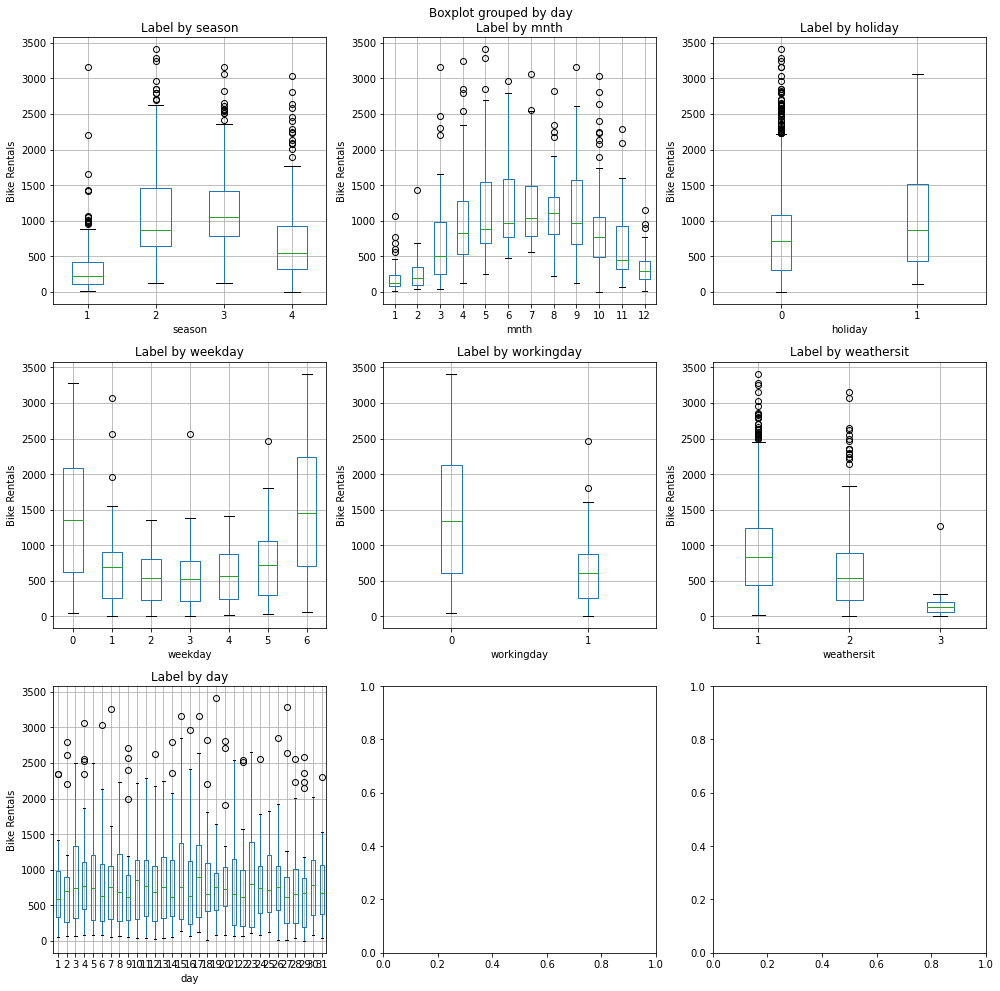

In [56]:
# plot a boxplot for the label by each categorical feature
fig, ax = plt.subplots(3, 3, figsize = (14,14))

for i,col in enumerate(categorical_features):
    if i==0: fig_row=0; fig_col=0
    if i==1: fig_row=0; fig_col=1
    if i==2: fig_row=0; fig_col=2
    if i==3: fig_row=1; fig_col=0
    if i==4: fig_row=1; fig_col=1
    if i==5: fig_row=1; fig_col=2
    if i==6: fig_row=2; fig_col=0
    if i==7: fig_row=2; fig_col=1
    bike_data.boxplot(column = 'rentals', by = col, ax = ax[fig_row,fig_col])
    ax[fig_row,fig_col].set_title('Label by ' + col)
    ax[fig_row,fig_col].set_ylabel("Bike Rentals")
fig.tight_layout()

The plots show some variance in the relationship between some category values and rentals. For example, there's a clear difference in the distribution of rentals on weekends (**weekday** 0 or 6) and those during the working week (**weekday** 1 to 5). Similarly, there are notable differences for **holiday** and **workingday** categories. There's a noticeable trend that shows different rental distributions in summer and fall months compared to spring and winter months. The **weathersit** category also seems to make a difference in rental distribution. The **day** feature we created for the day of the month shows little variation, indicating that it's probably not predictive of the number of rentals.

## Train a Regression Model

Now that we've explored the data, it's time to use it to train a regression model that uses the features we've identified as potentially predictive to predict the **rentals** label.  The first thing we need to do is to separate the features we want to use to train the model from the label we want it to predict.

In [57]:
# Separate features and labels
X, y = bike_data[['season','mnth', 'holiday','weekday','workingday','weathersit','temp', 'atemp', 'hum', 'windspeed']].values, bike_data['rentals'].values
print('Features:',X[:10], '\nLabels:', y[:10], sep='\n')

Features:
[[1.        1.        0.        6.        0.        2.        0.344167
  0.363625  0.805833  0.160446 ]
 [1.        1.        0.        0.        0.        2.        0.363478
  0.353739  0.696087  0.248539 ]
 [1.        1.        0.        1.        1.        1.        0.196364
  0.189405  0.437273  0.248309 ]
 [1.        1.        0.        2.        1.        1.        0.2
  0.212122  0.590435  0.160296 ]
 [1.        1.        0.        3.        1.        1.        0.226957
  0.22927   0.436957  0.1869   ]
 [1.        1.        0.        4.        1.        1.        0.204348
  0.233209  0.518261  0.0895652]
 [1.        1.        0.        5.        1.        2.        0.196522
  0.208839  0.498696  0.168726 ]
 [1.        1.        0.        6.        0.        2.        0.165
  0.162254  0.535833  0.266804 ]
 [1.        1.        0.        0.        0.        1.        0.138333
  0.116175  0.434167  0.36195  ]
 [1.        1.        0.        1.        1.        1.        

After separating the dataset, we now have numpy arrays named **X** containing the features, and **y** containing the labels.

We *could* train a model using all of the data; but it's common practice in supervised learning to split the data into two subsets; a (typically larger) set with which to train the model, and a smaller "hold-back" set with which to validate the trained model. This enables us to evaluate how well the model performs when used with the validation dataset by comparing the predicted labels to the known labels. It's important to split the data *randomly* (rather than say, taking the first 70% of the data for training and keeping the rest for validation). This helps ensure that the two subsets of data are statistically comparable (so we validate the model with data that has a similar statistical distribution to the data on which it was trained).

To randomly split the data, we'll use the **train_test_split** function in the **scikit-learn** library. This library is one of the most widely used machine learning packages for Python.

In [58]:
from sklearn.model_selection import train_test_split

# Split data 70%-30% into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

print ('Training Set: %d rows\nTest Set: %d rows' % (X_train.shape[0], X_test.shape[0]))

Training Set: 511 rows
Test Set: 220 rows


Now we have the following four datasets:

- **X_train**: The feature values we'll use to train the model
- **y_train**: The corresponding labels we'll use to train the model
- **X_test**: The feature values we'll use to validate the model
- **y_test**: The corresponding labels we'll use to validate the model

Now we're ready to train a model by fitting a suitable regression algorithm to the training data. We'll use a *linear regression* algorithm, a common starting point for regression that works by trying to find a linear relationship between the *X* values and the *y* label. The resulting model is a function that conceptually defines a line where every possible X and y value combination intersect.

In Scikit-Learn, training algorithms are encapsulated in *estimators*, and in this case we'll use the **LinearRegression** estimator to train a linear regression model.

In [59]:
# Train the model
from sklearn.linear_model import LinearRegression

# Fit a linear regression model on the training set
model = LinearRegression().fit(X_train, y_train)
print (model)

LinearRegression()


### Evaluate the Trained Model

Now that we've trained the model, we can use it to predict rental counts for the features we held back in our validation dataset. Then we can compare these predictions to the actual label values to evaluate how well (or not!) the model is working.

In [60]:
predictions = model.predict(X_test)
np.set_printoptions(suppress=True)
print('Predicted labels: ', np.round(predictions)[:10])
print('Actual labels   : ' ,y_test[:10])

Predicted labels:  [1896. 1184. 1007.  -28.  314.  385.  475.  590. 1476.  -22.]
Actual labels   :  [2418  754  222   47  244  145  240  555 3252   38]


Comparing each prediction with its corresponding "ground truth" actual value isn't a very efficient way to determine how well the model is predicting. Let's see if we can get a better indication by visualizing a scatter plot that compares the predictions to the actual labels. We'll also overlay a trend line to get a general sense for how well the predicted labels align with the true labels.

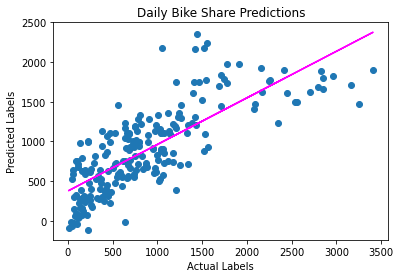

In [63]:
plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Daily Bike Share Predictions')
# overlay the regression line
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

There's a definite diagonal trend, and the intersections of the predicted and actual values are generally following the path of the trend line; but there's a fair amount of difference between the ideal function represented by the line and the results. This variance represents the *residuals* of the model - in other words, the difference between the label predicted when the model applies the coefficients it learned during training to the validation data, and the actual value of the validation label. These residuals when evaluated from the validation data indicate the expected level of *error* when the model is used with new data for which the label is unknown.

You can quantify the residuals by calculating a number of commonly used evaluation metrics. We'll focus on the following three:

- **Mean Square Error (MSE)**: The mean of the squared differences between predicted and actual values. This yields a relative metric in which the smaller the value, the better the fit of the model
- **Root Mean Square Error (RMSE)**: The square root of the MSE. This yields an absolute metric in the same unit as the label (in this case, numbers of rentals). The smaller the value, the better the model (in a simplistic sense, it represents the average number of rentals by which the predictions are wrong!)
- **Coefficient of Determination (usually known as *R-squared* or R<sup>2</sup>**): A relative metric in which the higher the value, the better the fit of the model. In essence, this metric represents how much of the variance between predicted and actual label values the model is able to explain.

> **Note**: You can find out more about these and other metrics for evaluating regression models in the [Scikit-Learn documentation](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics)

Let's use Scikit-Learn to calculate these metrics for our model, based on the predictions it generated for the validation data.

In [64]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)

rmse = np.sqrt(mse)
print("RMSE:", rmse)

r2 = r2_score(y_test, predictions)
print("R2:", r2)

MSE: 201972.55947035606
RMSE: 449.41357285951665
R2: 0.6040454736919187


So now we've quantified the ability of our model to predict the number of rentals. It definitely has *some* predictive power, but we can probably do better!

## Summary

Here we've explored our data and fit a basic regression model. In the next notebook, we will try a number of other regression algorithms to improve performance

## Further Reading
To learn more about Scikit-Learn, see the [Scikit-Learn documentation](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics).